In [1]:
import pandas as pd # 0.21.0
import numpy as np
from time import time

import scipy
from scipy import stats
import matplotlib.pyplot as plt

import quandl

In [ ]:
1. month
2. day
3. 5,10,20 mavg
4. lagged returns 1-20

In [92]:
np.random.seed(100)
quandl.ApiConfig.api_key = "eFys5fhhsTNVrsJEcQ5y"

In [116]:
def get_returns(ticker, start, end):
    try:
        df = quandl.get("WIKI/"+ticker, start_date=start, end_date=end)
    except Exception as e:
        print("Error in getting stock data: {}".format(e))

    df = pd.DataFrame(df['Adj. Close'] )
    df = pre_process(df)
    return df

def pre_process(df):
    df["log_returns"] =  np.log(df/df.shift(1))
    # NOTE: is a shift necessary here? I commented out, as the code seems to be shifting incorrectly.
    #df_index = df.index[0:-1]
    #df = df[1:]
    #df.index = df_index
    return df

In [100]:
df = get_returns("AAPL", "10-01-09", "17-10-17")

In [101]:
df.tail(5)

,Adj. Close,log_returns
Date,,
2017-10-11,156.55,0.004161
2017-10-12,156.00,-0.003519
2017-10-13,156.99,0.006326
2017-10-16,159.88,0.018241
2017-10-17,160.47,0.003683


In [102]:
# Shift data by 1 day as we dont want rolling average to include the day we are trying to predict.
df['5d_roll_ave'] = df['log_returns'].shift(1).rolling(window=5, center=False).mean().dropna()
df['10d_roll_ave'] = df['log_returns'].shift(1).rolling(window=10, center=False).mean().dropna()
df['20d_roll_ave'] = df['log_returns'].shift(1).rolling(window=20, center=False).mean().dropna()
#df = pd.merge(df, df_5_day_roll, left_index=True, right_index=True)
df = df.dropna()
df.head()

,Adj. Close,log_returns,5d_roll_ave,10d_roll_ave,20d_roll_ave
Date,,,,,
2010-02-10,25.075125,-0.005489,0.000337,-0.004850,-0.003427
2010-02-11,25.531864,0.018051,-0.004173,-0.006339,-0.003130
2010-02-12,25.751623,0.008570,0.006778,-0.000312,-0.002928
2010-02-16,26.139735,0.014959,0.004972,0.004239,-0.002209
2010-02-17,26.030498,-0.004188,0.009340,0.004356,-0.000618


### Date, Time features

In [103]:
df['Date'] = df.index
#df[['year','month','day']] = df.Date.str.split('-',expand=True)
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df.head()

,Adj. Close,log_returns,5d_roll_ave,10d_roll_ave,20d_roll_ave,Date,month,day
Date,,,,,,,,
2010-02-10,25.075125,-0.005489,0.000337,-0.004850,-0.003427,2010-02-10,2,10
2010-02-11,25.531864,0.018051,-0.004173,-0.006339,-0.003130,2010-02-11,2,11
2010-02-12,25.751623,0.008570,0.006778,-0.000312,-0.002928,2010-02-12,2,12
2010-02-16,26.139735,0.014959,0.004972,0.004239,-0.002209,2010-02-16,2,16
2010-02-17,26.030498,-0.004188,0.009340,0.004356,-0.000618,2010-02-17,2,17


In [104]:
del df['Date']
df.head()

,Adj. Close,log_returns,5d_roll_ave,10d_roll_ave,20d_roll_ave,month,day
Date,,,,,,,
2010-02-10,25.075125,-0.005489,0.000337,-0.004850,-0.003427,2,10
2010-02-11,25.531864,0.018051,-0.004173,-0.006339,-0.003130,2,11
2010-02-12,25.751623,0.008570,0.006778,-0.000312,-0.002928,2,12
2010-02-16,26.139735,0.014959,0.004972,0.004239,-0.002209,2,16
2010-02-17,26.030498,-0.004188,0.009340,0.004356,-0.000618,2,17


### Create lagged features

In [105]:
steps = 20
lags_df = (pd.concat(
    [df.log_returns.shift(i) for i in range(steps)],
    axis=1,
    keys=['log_returns'] + ['log_returns_L%s' % i for i in range(1, steps)]
).dropna()
)
# To ensure that only past frames are used to predict current steering.
# (e.g to predict target at t, we use t-1,t-2, etc.)
lags_df = lags_df.drop(['log_returns'], axis=1)
final_df = pd.merge(df, lags_df, left_index=True, right_index=True)

In [106]:

final_df.head()

,Adj. Close,log_returns,5d_roll_ave,10d_roll_ave,20d_roll_ave,month,day,log_returns_L1,log_returns_L2,log_returns_L3,...,log_returns_L10,log_returns_L11,log_returns_L12,log_returns_L13,log_returns_L14,log_returns_L15,log_returns_L16,log_returns_L17,log_returns_L18,log_returns_L19
Date,,,,,,,,,,,,,,,,,,,,,
2010-03-10,28.895074,0.008128,0.013129,0.012376,0.006939,3,10,0.017824,0.000594,0.038361,...,0.018089,-0.016892,-0.006237,-0.006219,0.001864,-0.004188,0.014959,0.008570,0.018051,-0.005489
2010-03-11,28.979893,0.002931,0.014295,0.011380,0.006815,3,11,0.008128,0.017824,0.000594,...,0.006676,0.018089,-0.016892,-0.006237,-0.006219,0.001864,-0.004188,0.014959,0.008570,0.018051
2010-03-12,29.121258,0.004866,0.013567,0.011005,0.007236,3,12,0.002931,0.008128,0.017824,...,0.012887,0.006676,0.018089,-0.016892,-0.006237,-0.006219,0.001864,-0.004188,0.014959,0.008570
2010-03-15,28.766560,-0.012255,0.006869,0.010203,0.006577,3,15,0.004866,0.002931,0.008128,...,0.021132,0.012887,0.006676,0.018089,-0.016892,-0.006237,-0.006219,0.001864,-0.004188,0.014959
2010-03-16,28.844953,0.002721,0.004299,0.006865,0.005536,3,16,-0.012255,0.004866,0.002931,...,-0.000670,0.021132,0.012887,0.006676,0.018089,-0.016892,-0.006237,-0.006219,0.001864,-0.004188


In [107]:
# convert return into binary to format for classification
final_df["y"] = final_df.apply(lambda x: 1 if x['log_returns'] > 0 else 0 , axis=1)


In [108]:
del final_df["log_returns"]

In [109]:
y = final_df.pop("y")
X = final_df

In [110]:
print("y shape: {}".format(y.shape))
print("X shape: {}".format(X.shape))

y shape: (1916,)
X shape: (1916, 25)


### Assess distribution and statistics of data

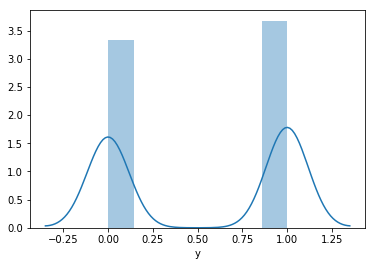

In [111]:

import seaborn as sns
%matplotlib inline
sns.distplot(y)

In [112]:
y.describe()

count    1916.000000
mean        0.525052
std         0.499502
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: y, dtype: float64

In [113]:
train_size = int(X.shape[0]*0.9)

### Split into train and test

In [114]:
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
print("y Train shape: {}".format(y_train.shape))
print("X Train shape: {}".format(X_train.shape))
print("y Test shape: {}".format(y_test.shape))
print("X Test shape: {}".format(X_test.shape))

y Train shape: (1724,)
X Train shape: (1724, 25)
y Test shape: (192,)
X Test shape: (192, 25)


### Train RandomForest classifier

In [115]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

rfc = RandomForestClassifier()
rfc_model = rfc.fit(X_train, y_train)
pred = rfc_model.predict(X_test)
print("Accuracy for Random Forest Model: %.2f" % (accuracy_score(y_test, pred) * 100))
print("RMSE for Random Forest Model: %.2f" % (rmse(y_test, pred) * 100))


Accuracy for Random Forest Model: 52.08
RMSE for Random Forest Model: 69.22
